# *Seattle Collision Severity Prediction*

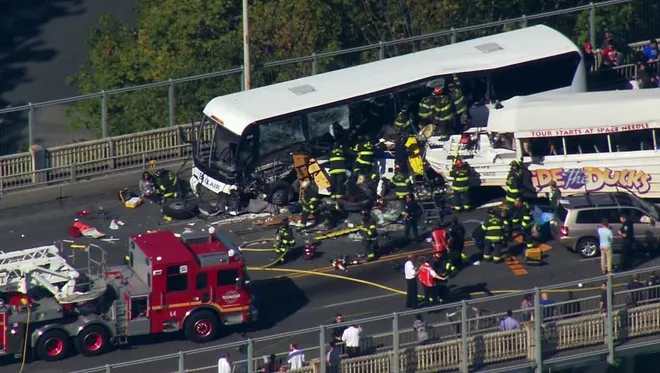

#### Importing the libraries which will be used in this notebook

In [ ]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, validation_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
import itertools
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 194673)
pd.set_option('display.max_columns', 37)


## **Business Undertanding**

####  Seattle, a city on Puget Sound in the Pacific Northwest.  Washington State’s largest city, it’s home to a large tech industry, with Microsoft and Amazon headquartered in its metropolitan area. The city is of high socio-economic value and a fast moving city .The city is  in a surge to improve the lifestyle of the people living over there .one of the  most important problem they are facing is traffic .The provided dataset consist of a large amount of  collision data recorded over many years in the seattle city .This dataset also provides various information which are some kind of related to the cause of the collision 

#### below the seattle collision dataset is loaded using pandas

### **Data**

In [ ]:
df = pd.read_csv('../input/seattle-sdot-collisions-data/Collisions.csv')

In [ ]:
df.columns

#### Just for my convenience ,  i have changed the column names

In [ ]:
df.rename(columns={'SEVERITYCODE': 'severity_code', 'X':'longitude', 'Y': 'latitude',
                   'ADDRTYPE':'addr_type', 'LOCATION': 'location','SEVERITYDESC':'severity_desc', 'COLLISIONTYPE':'collision_type',
                   'PERSONCOUNT':'person_count', 'PEDCOUNT': 'ped_count', 'PEDCYLCOUNT': 'ped_cycle_count', 'VEHCOUNT': 'veh_count',
                   'INCDTTM': 'inc_dt', 'JUNCTIONTYPE': 'junc_type', 'SDOT_COLCODE': 'case_code', 'SDOT_COLDESC': 'case_desc',
                   'UNDERINFL':'under_infl', 'WEATHER': 'weather', 'ROADCOND': 'roadcond', 'LIGHTCOND': 'light_cond',
                   'ST_COLCODE': 'st_code', 'ST_COLDESC': 'st_desc', 'HITPARKEDCAR':'hit_parked_car', 'SPEEDING':'speeding', 
                   'FATALITIES':'fatalities', 'INJURIES':'injuries', 'SERIOUSINJURIES':'serious_injuries'}, inplace=True)

In [ ]:
df.shape

#### It's really huge, A dataset consisting of 40 columns and 221266 rows 

#### lets take a look at the dataset

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
map = folium.Map(location=[47.606209, -122.332069], zoom_start=10)
map_clust = MarkerCluster().add_to(map)
location = df[['latitude', 'longitude']][df['longitude'].notnull()][:5000]
loc = location.values.tolist()
for i in range(len(loc)):
  folium.Marker(loc[i]).add_to(map_clust)
map

#### The above represented is the map of seattle and the locations where collisions took place .

### **Data Understanding**

**severity_code**
#### A code that corresponds to the severity of the collision

In [ ]:
df['severity_code'].value_counts().to_frame('counts')

**severity_desc**
A detailed description of the severity of the collision

In [ ]:
df['severity_desc'].value_counts().to_frame('counts')

#### 1 - Property damage only collision(collison causing damages only to properties)
#### 2 - injury collision(collison which caused injuries to the pedestrians or passenger involved in the collision)
#### 0 - unknown
#### 2b - the collision caused serious injuries to pedestrians or passengers
#### 3 - the collision lead to some death

**collison_type**
#### The type of collision

In [ ]:
df['collision_type'].value_counts().to_frame('counts')

**addr_type**
#### Collision address type:
• Alley
• Block
• Intersection

In [ ]:
df['addr_type'].value_counts().to_frame('counts')

#### this column is similar to the junc_type

In [ ]:
df['junc_type'].value_counts().to_frame('counts')

**weather**
#### A description of the weather conditions during the time of the collision.

In [ ]:
df['weather'].value_counts().to_frame('counts')

**roadcond**
#### The condition of the road during the collision

In [ ]:
df['roadcond'].value_counts().to_frame()

**light_cond**
#### The light conditions during the collision

In [ ]:
df['light_cond'].value_counts().to_frame('counts')

In [ ]:
df[['person_count', 'ped_count', 'ped_cycle_count', 'veh_count']].describe()

### **Data Cleaning & Pre-Processing**

#### This dataset is obtained from an external source and usually any dataset obtained will not be in a clean format ,it will always contain some missing values and some irrelevant data which are just trash to the dataset. This dataset too consist of a lot of missing values and useless datas .so before further processing the data it is important to clean the dataset

#### STATUS, INTKEY,OBJECTID, INCKEY, COLDETKEY,	REPORTNO, EXCEPTRSNCODE,	EXCEPTRSNDESC, INCDATE, INATTENTIONIND, PEDROWNOTGRNT, SDOTCOLNUM, SEGLANEKEY, CROSSWALKKEY has a lot of missing values and they are not useful and irrelevant for this dataset. so they are too dropped

In [ ]:
df = df[['longitude', 'latitude','location','severity_code',
        'severity_desc','collision_type', 'person_count', 'ped_count', 'ped_cycle_count',
       'veh_count','inc_dt','addr_type', 'junc_type', 'case_code', 'case_desc','under_infl',
       'speeding', 'weather', 'roadcond', 'light_cond','st_code', 'st_desc',
       'hit_parked_car', 'injuries', 'serious_injuries', 'fatalities']]

In [ ]:
df.isnull().sum()

#### The obtained dataset has a lot of missing values. lets first eliminate the unwanted parts of the dataset

In [ ]:
df1 = df[['latitude', 'longitude', 'severity_code', 'weather', 'roadcond', 'light_cond', 
          'speeding', 'under_infl', 'person_count', 'ped_count', 'ped_cycle_count', 'veh_count', 
          'injuries', 'serious_injuries', 'severity_desc', 'fatalities']]

##### The speeding column had a lot of missing values and consists of only 'y' means who are speedy ,converting Y->1 and nan->0 ,thus the speeding column's looking good

In [ ]:
df1['speeding'].replace(np.nan,0,inplace=True)
df1['speeding'].replace('Y', 1, inplace=True)
df1['speeding'].value_counts().to_frame('counts')

##### As said before the dataset has some useless data like unknown and others which won't fall under any of the category and they are a kind of outliers which ruin the dataset .hence they are all converted to nan.Hence paving way to group them under the category of missing values

In [ ]:
df1.replace(to_replace={'Unknown': np.nan, 
                        'Other':np.nan}, inplace=True)

##### dropping off all the missing data from the dataset

In [ ]:
df1.dropna(inplace=True)

In [ ]:
df1.isnull().sum()

##### The under the influece of alcohol has a lot of variables which are just the duplicate of themselves .hence changing them to a unique numeric data which will be good for processing the data

In [ ]:
df1['under_infl'].replace(to_replace={'Y':1, 'N':0, '1':1, '0':0}, inplace=True)

In [ ]:
df1['under_infl'].value_counts().to_frame('counts')

In [ ]:
df1['severity_code'].replace(to_replace={'2b':'4'}, inplace=True)

### **visualization**

In [ ]:
plt.style.use('ggplot')
ax = sns.countplot(df1['weather'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
plt.style.use('seaborn')
ax = sns.countplot(df1['severity_desc'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('severity')
plt.show()

In [ ]:
ax = sns.countplot(df1['roadcond'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
ax = sns.countplot(df1['light_cond'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(df1['under_infl'])

In [ ]:
ax = plt.scatter(df1['veh_count'], df1['person_count'])
plt.xlabel('vehicle_count')
plt.ylabel('person_couont')
plt.show()

In [ ]:
plt.scatter(df1['ped_count'], df1['person_count'])
plt.xlabel('pedestrian_count')
plt.ylabel('person_count')
plt.show()

In [ ]:
plt.scatter(df1['veh_count'], df1['injuries'])
plt.xlabel('vehicle count')
plt.ylabel('injuries count')
plt.show()

In [ ]:
sns.heatmap(df1.corr(), cmap='YlGnBu_r')
plt.show()

##### using one hot encoding to change the categorical variables. Its good to use pd.get_dummies ,its another way for one hot encoding as the column names of category comes along with it and its good to see.

In [ ]:
df2 = pd.concat([df1.drop(['weather', 'roadcond', 'light_cond','severity_desc'], axis=1),
                 pd.get_dummies(df1['weather']),
                 pd.get_dummies(df1['roadcond']),
                 pd.get_dummies(df1['light_cond'])], axis=1)
df2.reset_index(drop=True, inplace=True)

In [ ]:
df2.head().T

##### Correlation is a statistical technique that can show whether and how strongly pairs of variables are related. Finding the correlation among the features of the dataset helps understand the data better. For example, in the heatmap shown below, it can be observed that some features have a strong positive / negative correlation while most of them have weak / no correlation.

In [ ]:
sns.heatmap(df2.corr(), cmap='YlGnBu_r')
plt.show()

##### The next step is to divide the dataset into data values and labels that means to x and y .Then normalizing the data for feature scaling, passing the data to the train_test_split function.here ,we split the data into training data and testing data as x_train, x_test, y_train, y_test by choosing a split ratio of 0.2 ,means 20% of data used for testing

In [ ]:
x = df2.drop('severity_code', axis=1).values
y = df2['severity_code'].values
X = StandardScaler().fit(x).transform(x)
y = y.astype(int)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Modelling and Evaluation**

#### The process of modeling means training a machine learning algorithm to predict the labels from the features, tuning it for the business need, and validating it on holdout data.The output from modeling is a trained model that can be used for inference, making predictions on new data points.
#### Model Evaluation is an integral part of the model development process. It helps to find the best model that represents our data and how well the chosen model will work in the future. To avoid overfitting, both methods use a test set (not seen by the model) to evaluate model performance

#### Decision Tree makes decision with tree-like model. It splits the sample into two or more homogenous sets (leaves) based on the most significant differentiators in the input variables. To choose a differentiator (predictor), the algorithm considers all features and does a binary split on them (for categorical data, split by category; for continuous, pick a cut-off threshold). It will then choose the one with the least cost (i.e. highest accuracy), and repeats recursively, until it successfully splits the data in all leaves (or reaches the maximum depth).

#### Information gain for a decision tree classifier can be calculated either using the Gini Index measure or the Entropy measure, whichever gives a greater gain. A hyper parameter Decision Tree Classifier was used to decide which tree to use, DTC using entropy had greater information gain; hence it was used for this classification problem.


**Confusion Matrix**

#### The confusion matrix (or error matrix) is one way to summarize the performance of a classifier for binary classification tasks. This square matrix consists of columns and rows that list the number of instances as absolute or relative "actual class" vs. "predicted class" ratios.



In [ ]:
def cnf_mx(preds):
    cm = confusion_matrix(y_target=y_test, 
                          y_predicted=preds, 
                          binary=False)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()

**K-fold Cross-Validation**

#### In k-fold cross-validation, the data is divided into k folds. The model is trained on k-1 folds with one fold held back for testing. This process gets repeated to ensure each fold of the dataset gets the chance to be the held back set. Once the process is completed, we can summarize the evaluation metric using the mean or/and the standard deviation. 

**Stratified K-fold Cross-Validation**

#### Stratified K-Fold approach is a variation of k-fold cross-validation that returns stratified folds, i.e., each set containing approximately the same ratio of target labels as the complete data.

In [ ]:

def validate_models(model):
    kfold = KFold(n_splits=10, random_state=42)
    results_1 = cross_val_score(model, X, y, cv=kfold)
    print("kfold cross_val_score: %.2f%%" % (results_1.mean()*100.0))
    
    skfold = StratifiedKFold(n_splits=3, random_state=100)
    results_2  = cross_val_score(model, X, y, cv=skfold)
    print("stratified kfold cross_val _score: %.2f%%" % (results_2.mean()*100.0))

In [ ]:
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=5)
tree_model.fit(x_train, y_train)
print(tree_model)
yhat1 = tree_model.predict(x_test)
print('The accuracy of the decision tree classifier is {} with a max_depth of 5'.format(accuracy_score(y_test, yhat1)))

In [ ]:
print(classification_report(y_test, yhat1))

In [ ]:
cnf_mx(preds=yhat1)

In [ ]:
validate_models(DecisionTreeClassifier(criterion='entropy', max_depth=5))

#### Random Forest Classifier is an ensemble (algorithms which combines more than one algorithms of same or different kind for classifying objects) tree-based learning algorithm. RFC is a set of decision trees from randomly selected subset of training set. It aggregates the votes from different decision trees to decide the final class of the test object. Used for both classification and regression.

#### Similar to DTC, RFT requires an input that specifies a measure that is to be used for classification, along with that a value for the number of estimators (number of decision trees) is required. A hyper parameter RFT was used to determine the best choices for the above mentioned parameters. RFT with 75 DT’s using entropy as the measure gave the best accuracy when trained and tested on pre-processed accident severity dataset.


In [ ]:
forest_model = RandomForestClassifier(n_estimators=75)
forest_model.fit(x_train, y_train)
print(forest_model)
yhat2 = forest_model.predict(x_test)
print('the accuracy score for Random Forest Classifier is {}'.format(accuracy_score(y_test, yhat2)))

In [ ]:
print(classification_report(y_test, yhat2))

In [ ]:
cnf_mx(preds=yhat2)

In [ ]:
validate_models(RandomForestClassifier(n_estimators=75))

#### Logistic Regression is a classifier that estimates discrete values (binary values like 0/1, yes/no, true/false) based on a given set of an independent variables. It basically predicts the probability of occurrence of an event by fitting data to a logistic function. Hence it is also known as logistic regression. The values obtained would always lie within 0 and 1 since it predicts the probability.

#### The chosen dataset has more than two target categories in terms of the accident severity code assigned, one-vs-one (OvO) strategy is employed.
****

In [ ]:
log_reg_model = LogisticRegression(C=0.06)
log_reg_model.fit(x_train, y_train)
print(log_reg_model)
yhat3 = log_reg_model.predict(x_test)
print('The accuracy score for logistic regression is {}'.format(accuracy_score(y_test, yhat3)))

In [ ]:
print(classification_report(y_test, yhat3))

In [ ]:
cnf_mx(yhat3)

In [ ]:
validate_models(LogisticRegression())

### **Results**

#### The accuracies of all the  models is 100% which means we can accurately predict the severity of an accident. A bar plot is plotted below with the bars representing the accuracy of each model.

In [ ]:
plt.bar(['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression'], [1.,1.,1.])
plt.ylabel('accuracy')
plt.xlabel('machine learning models')
plt.show()

### **Conclusion**

#### Initially, The classifiers had an prediction accuracy of 66%-71%, however, upon going back to the data preparation and taking additional fields in the dataset improved the overall accuracy of all models.

#### The accuracy of the classifiers is excellent, i.e. 100%. This means that the model has trained well and fits the training data and performs well on the testing set as well as the training set. We can conclude that this model can accurately predict the severity of car accidents in Seattle.